# Prédiction de revenus : cibler de nouveaux clients potentiels 
*Etude data - Projet 7 - Nicolas Pasero (avril 2020)*\
*OpenClassrooms - ENSAE-ENSAI Formation Continue*\
*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

---

## Étude des classes de revenu des parents
Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :
 - le revenu moyen du pays, 
 - l'indice de Gini du pays.

*Il manque donc, pour un individu, la classe de revenu de ses parents*.

Ici nous supposons que l'on associe à chaque individu i une unique classe 'c_i_parent', quel que soit le nombre de parents de i.

Il est donc question de simuler cette information grâce à un coefficient (propre à chaque pays ) mesurant une corrélation entre le revenu de l'individu et le revenu de ses parents. Ce coefficient sera ici appelé *coefficient d'élasticité pj*, il mesure *la mobilité intergénérationnelle du revenu*.

Pour plus d'informations sur le calcul du coefficient d'élasticité, vous pouvez consulter ce [document](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf), notamment l'équation 1 de la page 8. Ce coefficient est déterminé par une régression linéaire simple dans laquelle le logarithme du revenu de l'enfant est une fonction du logarithme du revenu des parents: 

**ln(Ychild) = α + pj ln(Yparent) + ϵ**

*Les sources du coefficient d'élasticité* :\
Coefficients donnés par la Banque mondiale, dans GDIM dataset : http://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim. Le coefficient d'élasticité est donné pour certains pays, sous le nom d'IGE Income (relative IGM in income).
Ou bien des estimations provenant de multiples études, extrapolées à différentes régions du monde:  elles se trouvent dans le fichier elasticity.txt. Attention, ces données sont parfois anciennes.

#### Ci-dessous un aperçu de nos deux sources de données

In [75]:
#Fichier elasticity.txt
elasticity_file = pd.read_csv('p7_data/elasticity.txt', sep = "\t")[:16]
elasticity_file

,Coefficients of intergenerational elasticity between parents’ and
0,children’s income
1,| Base case | Optim...
2,| | (high...
3,----------------------------------------------...
4,Nordic European countries | 0.2 | ...
5,and Canada | | ...
6,----------------------------------------------...
7,Europe (except nordic | 0.4 | ...
8,countries) | | ...
9,----------------------------------------------...


In [76]:
#Chargement et traitement des données GDIM
gdim = pd.read_csv('p7_data/GDIMMay2018.csv').loc[:, ['countryname', 'iso3', 'region', 'IGEincome']]
gdim.rename(columns={'countryname': 'country', 'iso3' : 'country_code'}, inplace=True)
gdim.drop_duplicates(inplace=True)
gdim.drop_duplicates(subset=['country'], keep = 'last', inplace=True)
display(gdim.head(10))
display(gdim.shape)

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
183,Australia,AUS,High income,0.275000
243,Austria,AUT,High income,0.245267
279,Azerbaijan,AZE,Europe & Central Asia,NaN
351,Belgium,BEL,High income,0.183176
405,Benin,BEN,Sub-Saharan Africa,0.855116


(150, 4)

In [77]:
#Isolement des pays sans valeur pour la variable 'IGEincome'
missing_gdim = gdim[gdim['IGEincome'].isna()]
display(missing_gdim.tail())
display(len(missing_gdim))

,country,country_code,region,IGEincome
6298,"Venezuela, RB",VEN,Latin America & Caribbean,NaN
6366,Vanuatu,VUT,East Asia & Pacific,NaN
6378,West Bank and Gaza,PSE,Middle East & North Africa,NaN
6390,"Yemen, Rep.",YEM,Middle East & North Africa,NaN
6492,Zambia,ZMB,Sub-Saharan Africa,NaN


77

In [78]:
#Identification des pays sans valeur pour la variable 'IGEincome'
missing_countries_gdim = missing_gdim['country_code'].unique()
missing_countries_gdim = list(missing_countries_gdim)
len(missing_countries_gdim)

77

In [79]:
#Visualisation des régions concernées 
list(missing_gdim.region.unique())

['South Asia',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'High income',
 'East Asia & Pacific']

In [80]:
#Visualisation des pays concernés par la région 'High income'
missing_gdim[missing_gdim['region'] == 'High income']['country'].unique()

array(['Estonia', 'Hungary', 'Iceland', 'Israel', 'Lithuania', 'Poland',
       'Uruguay'], dtype=object)

In [81]:
#Boucle itérative afin d'imputer les valeurs NaN sur la variable 'IGEincome'
for code in missing_countries_gdim :
    if list(gdim.loc[gdim['country_code'] == code, 'region']) == ['South Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Sub-Saharan Africa']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Latin America & Caribbean']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.66
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['Europe & Central Asia']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.40                                                               
    elif list(gdim.loc[gdim['country_code'] == code, 'region']) == ['East Asia & Pacific']:
        gdim.loc[gdim['country_code'] == code, 'IGEincome'] = 0.50
    else : gdim.loc[gdim['country_code'] == code, 'IGEincome'] =  0.40                                     

In [82]:
#Jointure avec notre dataframe 'df' et celui obtenu 'gdim'
#'IGEincome' sera renommé en 'pj'
df_income_mobility = pd.merge(df, gdim[['country_code', 'IGEincome']], how='left', on='country_code')
df_income_mobility.rename(columns={'IGEincome': 'pj'}, inplace=True)
df_income_mobility.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


In [83]:
#Vérification des éventuelles valeurs manquantes
last_list_missing_countries = list(df_income_mobility[df_income_mobility['pj'].isna()]['country'].unique())
last_list_missing_countries

['Kosovo', 'Syrian Arab Republic']

*La Syrie est un pays d'Asie de l'Ouest > pj = 0.50*\
*Le Kosovo est un pays d'Europe du Sud  > pj = 0.40*

In [84]:
#Imputation des 2 dernières valeurs NaN dans le dataframe 
for country in last_list_missing_countries :
    if list(df_income_mobility[df_income_mobility['country'] == "Kosovo"]):
        df_income_mobility.loc[df_income_mobility['country'] == country, 'pj'] = 0.40
    else : 
        df_income_mobility.loc[df_income_mobility['country'] == country, 'pj'] = 0.50

In [85]:
#Dernière validation de la complétude du dataframe "df_income_mobility"
df_income_mobility.isna().any()

country_code    False
country         False
year            False
quantile        False
nb_quantiles    False
income          False
gdpppp          False
population      False
gini            False
income_avg      False
pj              False
dtype: bool

*Les booléens sont tous en False, visualisons le jeu de données.*

In [86]:
#Visualisation des premières lignes de l'échantillon 
display(df_income_mobility.head())
display(df_income_mobility.shape)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,income_avg,pj
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


(11600, 11)

L'échantillon contient 11600 individus, notre échantillon de travail a désormais son coefficient d'élasticité qui mesure la mobilité intergénérationnelle du revenu. A partir des 3 variables explicatives le revenu moyen du pays, l'indice de Gini du pays et le coefficient d'élasticité, *nous pourrons générer des classes de revenu des parents*.

### Revenus des parents selon une loi normale (de moyenne 0 et d'écart-type 1)
Les revenus des parents (exprimés en logs) sont générés de façon aléatoires selon une loi normale. La moyenne et variance n'ont aucune incidence sur le résultat final. *n doit-être supérieur à 1000 fois le nombre de quantiles*.

In [87]:
pj = 0.33                #Coefficient d'élasticité d'un pays j (ici la France sera prise pour exemple)
nb_quantiles = 100       #Nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles    #Taille de l'échantillon

In [88]:
#Utilisation de scipy pour générer aléatoirement la variable 'ln(Yparent)'
ln_y_parent = st.norm(0,1).rvs(size=n)

### Terme d'erreur ϵ selon une loi normale (de moyenne 0 et d'écart-type 1)
Génération aléatoire d'une réalisation du terme d'erreur epsilon. 

In [89]:
#Utilisation de scipy pour générer aléatoirement epsilon
residues = st.norm(0,1).rvs(size=n)

### Revenus des enfants ychild 
Les valeurs des revenus enfants ychild sont calculées pour une valeur donnée de pj (ici 0.33). A ce stade, ychild contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.

In [90]:
#Génération des revenus des parents et des enfants selon les éléments cités ci-dessus
#Application de la fonction generate_incomes()
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

y_child, y_parents = generate_incomes(n, pj)

### Calcul des classes de revenu des enfants et des parents selon les n individus générés précédemment
Pour chacun des n individus générés, les classes de revenu sont calculées selon ychild et yparent.

In [91]:
#Création d'un échantillon nommé "sample" via deux fonctions répondant aux critères liés aux quantiles
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [92]:
#Visualisation des 5 premières classes de revenu enfants et parents
display(sample.head())
display(sample.shape)

,y_child,y_parents,c_i_child,c_i_parent
0,0.245386,0.753879,10,39
1,1.083642,1.480475,53,66
2,0.725011,7.727023,38,99
3,0.154426,0.073232,4,1
4,0.214003,0.340997,8,15


(100000, 4)

*L'échantillon a été réalisé de façon aléatoire, d'un côté nous avons les individus, et de l'autre, ce qui nous intéresse, les classes de revenu enfants et parents.*

### Estimation de la distribution conditionnelle des classes de revenus parents pour chaque classe enfant
Les calculs sont toujours dépendants du coefficient d'élasticité pj du pays, dans notre cas d'exemple nous sommes toujours en pj = 0.33 pour la France.

In [93]:
#utilisation des fonctions de distribution et de probabilité conditionnelles
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]


cd = conditional_distributions(sample, nb_quantiles)


In [94]:
#Itération selon nos classes de revenu
nb_quantiles = 101
cd = conditional_distributions(sample, nb_quantiles)

class myInformativeException(Exception):
    def __init__(self, count):
        self.count = count
proba = []
try:        
    for x, y in zip(sample['c_i_child'], sample['c_i_parent']):
        p = proba_cond(y, x, cd)
        proba.append(p)
except myInformativeException as e:
    print("Error on ", e.count)

sample['proba'] = proba
sample.head()

,y_child,y_parents,c_i_child,c_i_parent,proba
0,0.245386,0.753879,10,39,0.008
1,1.083642,1.480475,53,66,0.016
2,0.725011,7.727023,38,99,0.005
3,0.154426,0.073232,4,1,0.025
4,0.214003,0.340997,8,15,0.011


*Graphiquement nous pourrons mieux comprendre la corrélation entre le revenu de l'individu et le revenu de ses parents*.

### Visualisation des distributions conditionnelles
A des fins de vérification, nous pouvons créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj: l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9).

In [95]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_high(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Forte mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.savefig('p7_graphic/distri_cond_forte_mobilite.jpg')
    plt.show()


**Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de pj :**

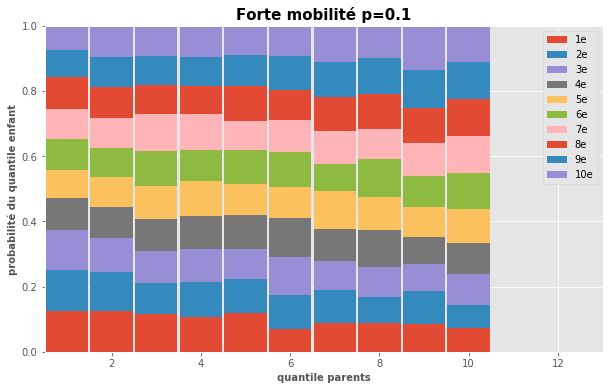

In [96]:
#Exemple d'une forte mobilité avec un pj = 0.1
pj_strong = 0.1                
nb_quantiles_strong = 10       
n_strong  = 1000*nb_quantiles_strong   

y_child_strong, y_parents_strong = generate_incomes(n_strong, pj_strong)
sample_strong = compute_quantiles(y_child_strong, y_parents_strong, nb_quantiles_strong)
cd_strong = conditional_distributions(sample_strong, nb_quantiles_strong)
plot_conditional_distributions_high(pj_strong, cd_strong, nb_quantiles_strong)

In [97]:
#Fonction permettant de visualiser le comportement des distributions conditionnelles 
def plot_conditional_distributions_low(p, cd, nb_quantiles):
    plt.figure(figsize = (10, 6))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Faible mobilité " + "p=" + str(p), fontsize=15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize=10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=10, fontweight='bold')
    
    plt.savefig('p7_graphic/distri_cond_faible_mobilite.jpg')
    plt.show()


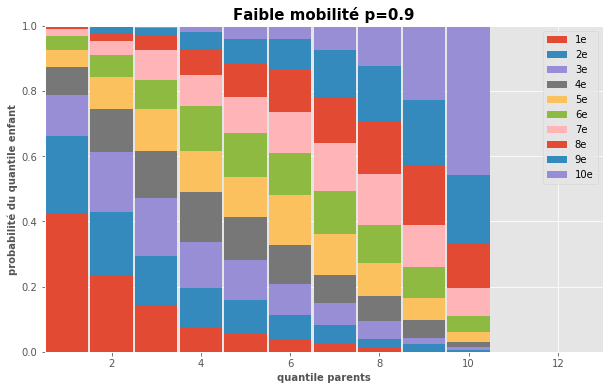

In [98]:
#Exemple d'une très faible mobilité avec un pj = 0.9
pj_low = 0.9                
nb_quantiles_low = 10       
n_low  = 1000*nb_quantiles_low   

y_child_low, y_parents_low = generate_incomes(n_low, pj_low)
sample_low = compute_quantiles(y_child_low, y_parents_low, nb_quantiles_low)
cd_low = conditional_distributions(sample_low, nb_quantiles_low)
plot_conditional_distributions_low(pj_low, cd_low, nb_quantiles_low)

*Les deux exemples démontrent clairement des situations extrêmes révélatrices de la mobilité des classes de revenu enfants / parents. Dans une situation à faible mobilité intergénérationnelle, prenons l'exemple de la 10ème classe parents pour laquelle il y a moins de 50% de mobilité chez les enfants, en d'autres termes les enfants resteront majoritairement dans la classe de revenu de leurs parents.*

### Suppression des individus
Pour éviter toute confusion, les individus générés sont supprimés (car inutiles pour la suite), seules les distributions conditionnelles sont conservées.

In [99]:
sample = sample.iloc[:, 2:]
sample.head()

,c_i_child,c_i_parent,proba
0,10,39,0.008
1,53,66,0.016
2,38,99,0.005
3,4,1,0.025
4,8,15,0.011


### Nouvel échantillon : 500 fois plus grand que celui de la World Income Distribution
Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, il y aura 499 "clones". 
*La taille du nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution*.

In [100]:
#Cet échantillon sera nommé "df_wid500", clone représentatif des individus de la WID
df_wid500 = df_income_mobility[['country_code', 'country', 'quantile', 'population', 
                                'income', 'income_avg', 'gini', 'pj']]

df_wid500 = pd.concat([df_wid500]*500, ignore_index=True)
display(df_wid500.head())
display(df_wid500.shape)

,country_code,country,quantile,population,income,income_avg,gini,pj
0,ALB,Albania,1,3002678.0,728.89795,2994.829902,0.3,0.815874
1,ALB,Albania,2,3002678.0,916.66235,2994.829902,0.3,0.815874
2,ALB,Albania,3,3002678.0,1010.91600,2994.829902,0.3,0.815874
3,ALB,Albania,4,3002678.0,1086.90780,2994.829902,0.3,0.815874
4,ALB,Albania,5,3002678.0,1132.69970,2994.829902,0.3,0.815874


(5800000, 8)

### Attribution des classes parents aux 500 individus de chaque pays
Pour chaque $c_{i,child}$ et chaque pays, il y a donc 500 individus. Maintenant il est question d'attribuer aux 500 individus leurs classes $c_{i,parent}$ conformément aux distributions trouvées précédemment. Par exemple, si P($c_{i,parent}$=8|$c_{i,child}$=5,$p_{j}$=0.9) = 0.03 , alors la classe $c_{i,parent}$ sera 8 à 15 des 500 individus du pays j ayant $c_{i,child}$=5 , car 500*0.03 = 15.

In [101]:
#Coefficient d'élasticité / code pays
country_income = df_income_mobility[['country_code', 'pj']]
country_income

,country_code,pj
0,ALB,0.815874
1,ALB,0.815874
2,ALB,0.815874
3,ALB,0.815874
4,ALB,0.815874
...,...,...
11595,COD,0.707703
11596,COD,0.707703
11597,COD,0.707703
11598,COD,0.707703


**Le code suivant a été lancé non pas sur ma machine, mais sur Google Colab puis enregistrer sous fichier csv.Plus d'une heure de calcul a été nécessaire.**

In [ ]:
%%time

#Liste de toutes les distributions conditionnelles
nb_quantiles = 100
n = 100*500
start_time = time.time()

list_cd = {}
for i, row in enumerate(country_income.iterrows()):
    print(f"""{time.time()-start_time:.2f}s - pays {i+1}/{len(country_income)}""")
    y_child, y_parents = generate_incomes(n, row[1][0])
    sample_final = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample_final, nb_quantiles)
    list_cd[row[0]] = cd.tolist()

In [ ]:
%%time

#Boucle itérative sur chaque pays
df_wid500['c_k_parent'] = NaN

for i, code_pays in enumerate(df_income_mobility['country_code'].drop_duplicates().values):        
    #seconde boucle sur chaque classe de revenu
    for c_parents in np.arange(1,101, dtype='int8'):
        #Récupération des distributions de la liste 'list_cd'
        dc = list_cd[code_pays][c_parents-1]
        
        #calcul des valeurs en fonction de cette distribution 
        c_k_parent = []
        for i in range(len(dc)):
            classe_parent = int(dc[i]*500)
            c_k_parent.extend([i+1]*classe_parent)
        
        #affectation des valeurs aux individus de l'échantillon
        df_wid500.loc[(df_wid500['country_code'] == code_pays) & 
                      (df_wid500['quantile'] == c_parents), 'c_k_parent'] = c_k_parent
            

In [102]:
#Chargement de l'échantillon "df_wid500" issu du fichier df_wid500.csv généré sur Colab
df_wid500 = pd.read_csv('p7_data/df_wid500.csv')
df_wid500.drop(['Unnamed: 0', 'pj'], axis=1, inplace=True)
display(df_wid500.shape)
display(df_wid500.head())

(5800000, 8)

,country_code,country,quantile,c_k_parent,population,income,income_avg,gini
0,ALB,Albania,1,1,3002678.0,728.89795,2994.829902,0.3
1,ALB,Albania,2,1,3002678.0,916.66235,2994.829902,0.3
2,ALB,Albania,3,1,3002678.0,1010.91600,2994.829902,0.3
3,ALB,Albania,4,1,3002678.0,1086.90780,2994.829902,0.3
4,ALB,Albania,5,1,3002678.0,1132.69970,2994.829902,0.3


[Retour vers la page notebook précédente (Analyse de la diversité des pays, clustering, Gini, courbe de Lorenz…)](https://github.com/nalron/project_income_analysis/blob/french_version/p7_notebook02.ipynb)

[Voir la suite du projet : ANOVA, régression linéaire et tests statistiques](https://github.com/nalron/project_income_analysis/blob/french_version/p7_notebook04.ipynb)